# Exposure Time Calculator

MASS Astrophysical Techniques – Homework 3 (2024/2025) \
Thara Caba

## Task 1

Write a program in Python that, based on the input characteristics of the telescope (mirror diameter $D$ and f-number $f/\#$), properties of the CCD chip ($q$, $S_\text{dc}$, $S_\text{ro}^2$, $u$), the observed object 
(magnitude $V$, seeing/PSF $r$), and the characteristics of the sky at the observatory site ($S_\text{sky}$), calculates the exposure time needed to achieve a given SNR. 

Assume the source's shape corresponds to a circular aperture of a given radius $r$ (in arcseconds), that the observation is conducted in the $V$-filter with a bandwidth of $900\,\text{\AA}$ (Assume that the flux is constant within this interval. This assumption is valid because we are 
estimating the order of magnitude for the exposure time, not its exact value. Otherwise, things become more complicated.). Assume the object is at the zenith ($X = 1$), and the flux for a zero-magnitude source is $f_0 = 1000\,\text{e}^-/\text{s}/\text{cm}^2/\text{\AA}$. Provide plots showing the dependence of the exposure time from: 

1. SNR = 3,1003 for $r = \{0.01, 0.1, 0.5, 1, 3\}$ arcsec
2. $V = 10,30$ for $D = \{1, 2.5, 6, 11\}$ m
3.  $B_\text{sky} = 18,24$ mag/arcsec$^2$ for $r = \{0.01, 0.1, 0.5, 1, 3\}$ arcsec
4.  $q = 0.35,0.99$ for $u = \{5, 14, 27, 50\}\,\mu$m

The above task is for a point source. However, the exposure time can also be estimated for an extended source (e.g., a galaxy). Assume the source brightness is $B_\text{sig} = 25$ mag/arcsec$^2$ and that it covers $4 \times 4$ pixels on the CCD chip. Provide plots showing changes in exposure time for SNR = $[3, 1003]$ and $n = \{4, 15, 70\}$. 

Unless otherwise stated, assume the following default parameters: 

$D = 8\,\text{m}$, $q = 0.7$, $V = 25^m$
$f/\# = 2.77$, $S_\text{dc} = 3\,\text{e}^-/\text{s}/\text{pix}$, $B_\text{sky} = 22\,\text{mag}/\text{arcsec}^2$
$S_\text{ro}^2 = 5\,\text{e}^-/\text{pix}$, $r = 2\,\text{arcsec}$
$u = 27\,\mu$m, $\text{SNR} = 10$

The report can be submitted in the form of a Jupyter notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Default parameters
D = 8  # Mirror diameter in meters
q = 0.7  # Quantum efficiency
V = 25  # Magnitude of the object
f_number = 2.77  # f/#
Sdc = 3  # Dark current in e-/s/pix
Ssky = 25  # Sky brightness in mag/arcsec^2
Sro2 = 5  # Read-out noise in e-/pix
r = 2  # Seeing/PSF radius in arcseconds
u = 27  # Pixel size in micrometers
SNR_target = 10  # Target signal-to-noise ratio

bandwidth = 900  # V-filter bandwidth in Å
X = 1  # Zenith factor
f0 = 1000  # Flux for a zero-magnitude source in e-/s/cm^2/Å

In [5]:
# Functions for calculations
def flux_from_magnitude(magnitude):
    """Calculate the flux for a given magnitude."""
    return f0 * 10**(-0.4 * magnitude)

def background_electrons(Ssky, r, u):
    """Calculate background electrons per pixel."""
    arcsec2_per_pix = (u / 1e6 / f_number * 206265)**2
    return flux_from_magnitude(Ssky) * arcsec2_per_pix * np.pi * (r**2)

def calculate_exposure_time(SNR, D, r, V, Ssky, Sdc, Sro2, q):
    """Calculate exposure time needed to achieve the given SNR."""
    flux_signal = flux_from_magnitude(V) * (np.pi * (r**2))
    aperture_area = np.pi * (D / 2)**2
    signal = flux_signal * aperture_area * bandwidth * q
    
    background = background_electrons(Ssky, r, u)
    thermal_noise = Sdc
    readout_noise = Sro2
    
    noise = np.sqrt(
        signal
        + background
        + thermal_noise
        + readout_noise
    )
    
    exposure_time = (SNR**2 * noise**2) / (signal**2)
    return exposure_time

# Generate plots for the required dependencies
def plot_exposure_vs_snr():
    r_values = [0.01, 0.1, 0.5, 1, 3]
    snr_values = [3, 1003]
    for r in r_values:
        times = [calculate_exposure_time(snr, D, r, V, Ssky, Sdc, Sro2, q) for snr in snr_values]
        plt.plot(snr_values, times, label=f"r = {r} arcsec")
    plt.xlabel("SNR")
    plt.ylabel("Exposure Time (s)")
    plt.title("Exposure Time vs SNR")
    plt.legend()
    plt.grid()
    plt.show()

def plot_exposure_vs_magnitude():
    V_values = [10, 30]
    D_values = [1, 2.5, 6, 11]
    for D in D_values:
        times = [calculate_exposure_time(SNR_target, D, r, V, Ssky, Sdc, Sro2, q) for V in V_values]
        plt.plot(V_values, times, label=f"D = {D} m")
    plt.xlabel("Magnitude (V)")
    plt.ylabel("Exposure Time (s)")
    plt.title("Exposure Time vs Magnitude")
    plt.legend()
    plt.grid()
    plt.show()

def plot_exposure_vs_sky_brightness():
    Bsky_values = [18, 24]
    r_values = [0.01, 0.1, 0.5, 1, 3]
    for r in r_values:
        times = [calculate_exposure_time(SNR_target, D, r, V, Bsky, Sdc, Sro2, q) for Bsky in Bsky_values]
        plt.plot(Bsky_values, times, label=f"r = {r} arcsec")
    plt.xlabel("Sky Brightness (mag/arcsec^2)")
    plt.ylabel("Exposure Time (s)")
    plt.title("Exposure Time vs Sky Brightness")
    plt.legend()
    plt.grid()
    plt.show()

def plot_exposure_vs_quantum_efficiency():
    q_values = [0.35, 0.99]
    u_values = [5, 14, 27, 50]
    for u in u_values:
        times = [calculate_exposure_time(SNR_target, D, r, V, Ssky, Sdc, Sro2, q) for q in q_values]
        plt.plot(q_values, times, label=f"u = {u} μm")
    plt.xlabel("Quantum Efficiency (q)")
    plt.ylabel("Exposure Time (s)")
    plt.title("Exposure Time vs Quantum Efficiency")
    plt.legend()
    plt.grid()
    plt.show()

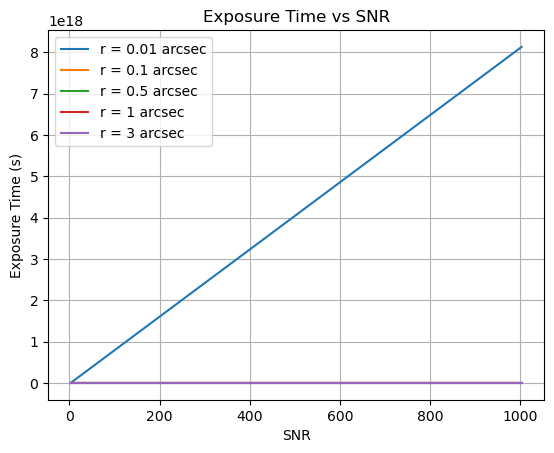

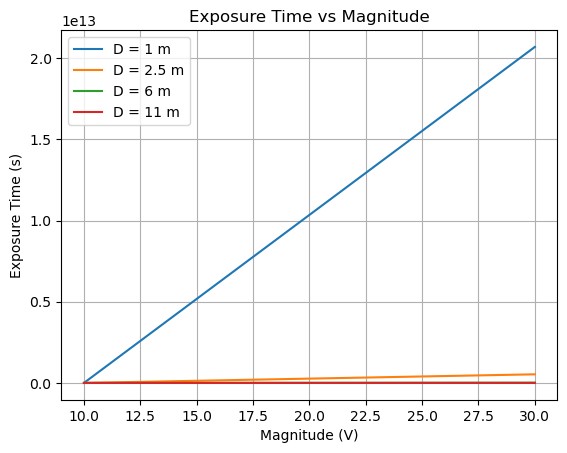

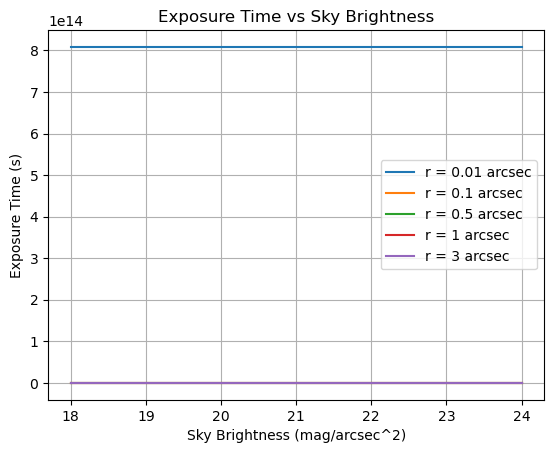

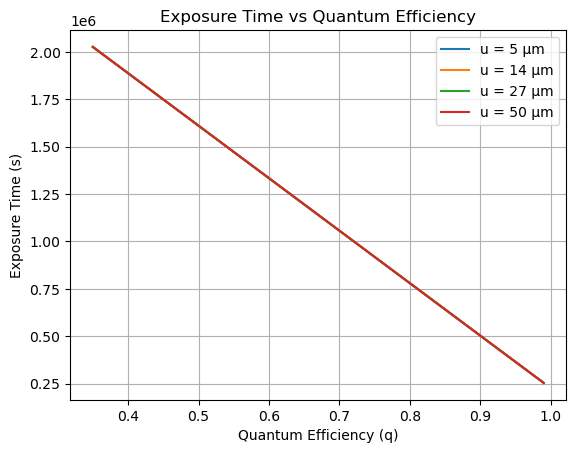

In [6]:
# Run the plotting functions
plot_exposure_vs_snr()
plot_exposure_vs_magnitude()
plot_exposure_vs_sky_brightness()
plot_exposure_vs_quantum_efficiency()

## Task 2

Calculate the exposure time for the Andromeda Galaxy (M31) to be observed with the Milanković telescope equipped with an SBIG STXL-6303E CCD camera. 
Assume the sky brightness is $B_\text{sky} = 19\,\text{mag}/\text{arcsec}^2$. The required SNR is 100. 

In [7]:
# Parameters specific to Task 2
D_task2 = 1.4  # Diameter of the Milanković telescope in meters
q_task2 = 0.68  # Quantum efficiency of the SBIG STXL-6303E CCD camera
Sdc_task2 = 0.5  # Dark current in e-/s/pix for SBIG STXL-6303E
Sro2_task2 = 15  # Readout noise in e-/pix for SBIG STXL-6303E
u_task2 = 24  # Pixel size in micrometers
Bsky_task2 = 19  # Sky brightness in mag/arcsec^2
SNR_task2 = 100  # Desired signal-to-noise ratio
Bsig_task2 = 25  # Surface brightness of M31 in mag/arcsec^2
n_pixels = 4 * 4  # M31 covers 4x4 pixels on the CCD

In [8]:
# Function to calculate exposure time for an extended source
def calculate_exposure_time_extended(SNR, D, q, Bsig, Bsky, Sdc, Sro2, n_pixels):
    """Calculate exposure time for an extended source."""
    aperture_area = np.pi * (D / 2)**2  # Aperture area of the telescope
    signal_per_arcsec2 = flux_from_magnitude(Bsig) * aperture_area * bandwidth * q
    signal = signal_per_arcsec2  # Surface brightness is uniform over the area
    total_signal = signal * n_pixels  # Sum up for all pixels

    background_per_arcsec2 = flux_from_magnitude(Bsky) * aperture_area * q
    background = background_per_arcsec2 * n_pixels  # Sum up for all pixels

    thermal_noise = Sdc * n_pixels
    readout_noise = Sro2 * n_pixels

    noise = np.sqrt(total_signal + background + thermal_noise + readout_noise)

    # Calculate exposure time
    exposure_time = (SNR**2 * noise**2) / (total_signal**2)
    return exposure_time

In [9]:
# Calculate exposure time for the Andromeda Galaxy
exposure_time_m31 = calculate_exposure_time_extended(
    SNR_task2, D_task2, q_task2, Bsig_task2, Bsky_task2, Sdc_task2, Sro2_task2, n_pixels
)

print(f"Exposure time required for M31 with SNR = {SNR_task2}: {exposure_time_m31:.2f} seconds")

Exposure time required for M31 with SNR = 100: 1091491460238.80 seconds
